# Модель в относительных параметров электрической схемы

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import islice

In [2]:
from functions.functions_under_study import var

Параметры графиков.

In [3]:
user_figsize = (12, 8)
user_fontsize = 14

## Импорт обучающих данных

Считываем из файлов и демасштабируем наборы частотных характеристик импеданса реактора.

In [4]:
# Data interpolation Enable.
iterpEnable = True
N_points = 10000
# Current meas. resistor.
Ri = 20

file_list = ['uncoated', 'coated']
N = len(file_list)
import_data = np.empty(N, dtype=object)
for n, file_name in enumerate(file_list):
    import_data[n] = np.loadtxt('AP300/' + file_name + '.dat', skiprows=1)
    # Data descaling.
    import_data[n][:,var.mag_db.value] += 20*np.log10(Ri)
    import_data[n][:,var.ph_deg.value] = np.unwrap(import_data[n][:,var.ph_deg.value]*np.pi/180 + np.pi)*180/np.pi

Интерполяция (если включено).

In [5]:
data = np.empty(N, dtype=object)
for n in range(N):
    if iterpEnable:
        data[n] = np.zeros((N_points, len(var)))
        data[n][:,var.freq.value] = np.logspace(np.log10(min(import_data[n][:,var.freq.value])),
                                                np.log10(max(import_data[n][:,var.freq.value])),
                                                N_points)
        for k in islice(var, var.mag_db.value, None):
            data[n][:,k.value] = np.interp(data[n][:,var.freq.value],
                                            import_data[n][:,var.freq.value],
                                            import_data[n][:,k.value])
    else:
        data[n] = import_data[n].copy()

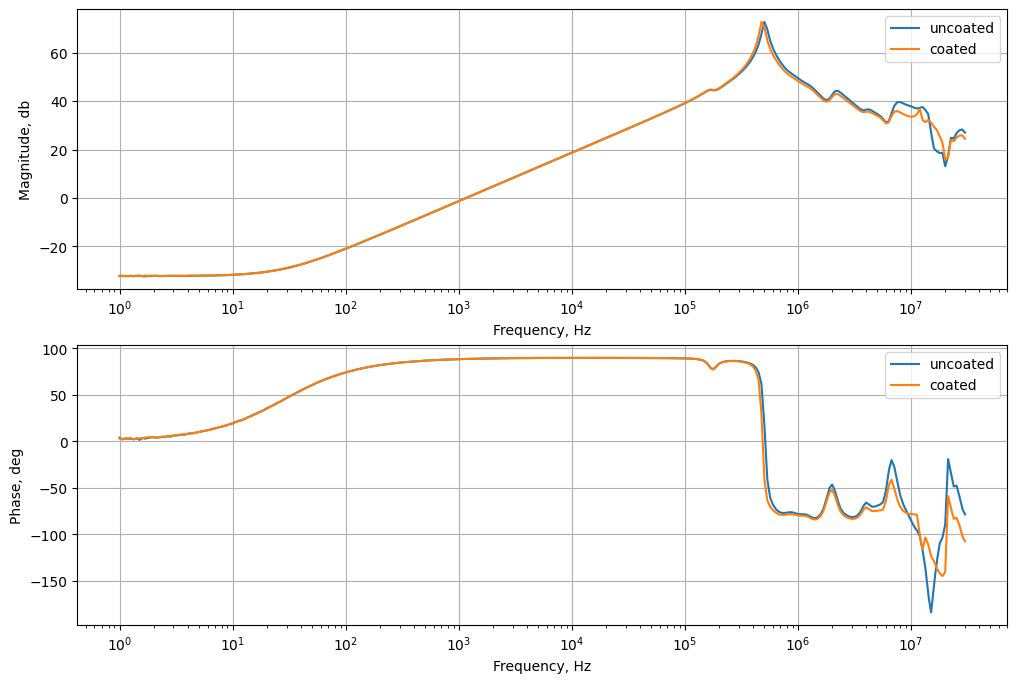

In [6]:
user_ylabel = ['Magnitude, db', 'Phase, deg']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_figsize)
for idx in range(2):
    ax = axes[idx]
    for n in range(N):
        ax.plot(data[n][:, var.freq.value], data[n][:, idx + 1], label=file_list[n])
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Frequency, Hz')
    ax.set_ylabel(user_ylabel[idx])
    ax.grid(True)
plt.show()

## Тест градиента

In [7]:
from functions.functions_under_study import reactor_model_gain, reactor_model_gain_abs, loss_func, grad_func

In [8]:
# Select dataset.
N_DATA = 0

# Инициализируем относительные коэффициенты.
w_coeff_1 = np.array([1.0]*3)

Численный расчет.

In [9]:
# Принимаем шаг в 0.001% относительно начального приближения и вводим соответствующие приращения.
w_step = 1e-5 * w_coeff_1
w_coeff = w_coeff_1 - w_step
w_coeff_2 = w_coeff_1 + w_step

# Массивы для каждой переменной отдельно.
x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]

# Конвертируем в сетку.
X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')

# Формируем массив значений функции потерь, для вычисления градиента.
# Initialize array to store loss values.
loss_func_grad = np.zeros_like(X1)
# Compute loss at each point in the grid.
# Note: This loop can be slow for large grids. Vectorization is better if possible.
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        for k in range(X1.shape[2]):
            w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
            loss_func_grad[i,j,k] = loss_func(
                freq=data[N_DATA][:, var.freq.value],
                y=data[N_DATA][:, var.mag_db.value],
                w=w_local)
# ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
grad = np.zeros((len(grad_grid),))
# Выбираем значение в самом центре окрестности.
for idx, grad_axis in enumerate(grad_grid):
    grad[idx] = grad_axis[1][1,1]

grad_norm = np.linalg.norm(grad, ord=None, axis=None)

Расчет по формулам.

In [10]:
grad1 = grad_func(
    freq=data[N_DATA][:, var.freq.value],
    y=data[N_DATA][:, var.mag_db.value],
    w=w_coeff_1)
grad_norm1 = np.linalg.norm(grad1, ord=None, axis=None)

In [11]:
print('Numerical grad:\n', np.round(grad,2))
print('Equation grad:\n', np.round(grad1,2))
print('Numerical grad norm:\n', np.round(grad_norm,2))
print('Equation grad norm:\n', np.round(grad_norm1,2))

Numerical grad:
 [-63.09 -19.77 -80.91]
Equation grad:
 [-63.09 -19.77 -80.91]
Numerical grad norm:
 104.49
Equation grad norm:
 104.48


## Тест визуальный

In [12]:
#R_b = 6e3

# Base parameters.
L_b = 100e-6
r_b = 10e-3
C_b = 100e-12

# Relative parameters
w_sel = np.array([136e-6/L_b, 25e-3/r_b, 725e-12/C_b])

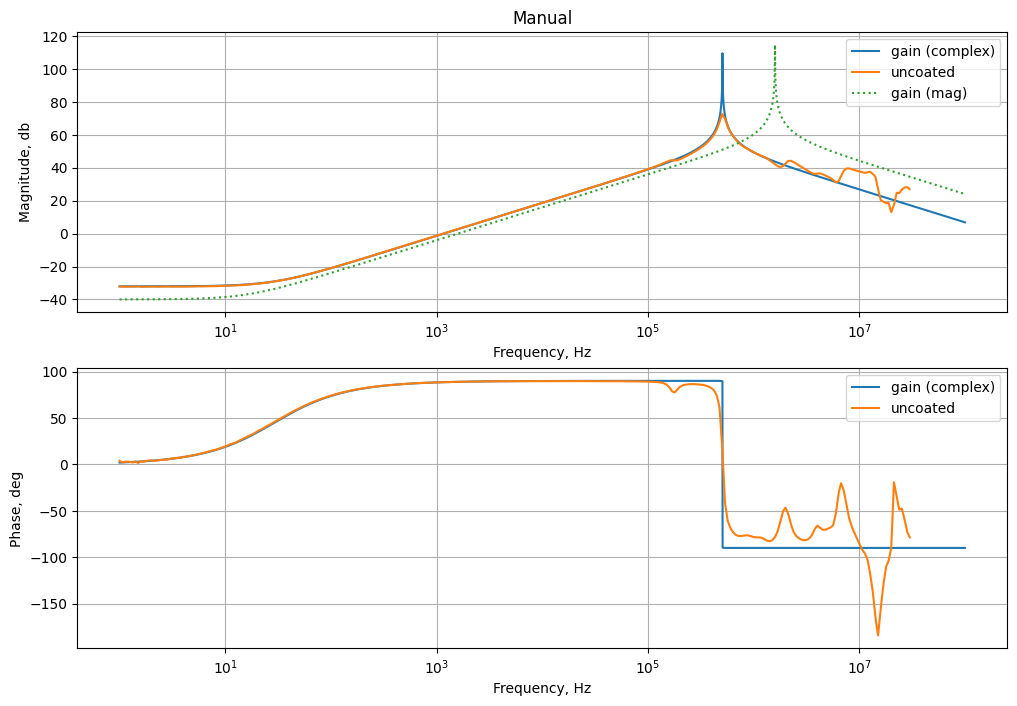

In [13]:
# Create frequency array.
f_min = 1
f_max = 100e6
freq = np.logspace(np.log10(f_min), np.log10(f_max), N_points)
#freq = data[N_DATA][:, var.freq.value]

abs_phase_dataset = reactor_model_gain(    freq, w_sel[0]*L_b, w_sel[1]*r_b, w_sel[2]*C_b)#, R)
abs_dataset       = reactor_model_gain_abs(freq, w_coeff_1[0]*L_b, w_coeff_1[1]*r_b, w_coeff_1[2]*C_b)#, R)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=user_figsize)
for idx, ax in enumerate(axs):
    ax.plot(freq, abs_phase_dataset[idx], label='gain (complex)')
    ax.plot(data[N_DATA][:, var.freq.value], data[N_DATA][:, idx + 1], label=file_list[N_DATA])
    if idx == 0:
        ax.set_title('Manual')
        ax.plot(freq, abs_dataset, ':', label='gain (mag)')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Frequency, Hz')
    ax.set_ylabel(user_ylabel[idx])
    ax.grid(True)
plt.show()

## Поиск оптимальных параметров

### Оптимизация с численным градиентом

In [14]:
def model_fit(X_train, y_train, lr_multiplier, lr_coeff, tolerance):

    iteration_max = 100000
    
    # Инициализируем коэффициенты.
    w_coeff_1 = np.array([0.9, 1.1, 1.2])

    # Принимаем шаг в 0.001% относительно начального приближения и вводим соответствующие приращения.
    w_step = 1e-5 * w_coeff_1
    w_coeff = w_coeff_1 - w_step
    w_coeff_2 = w_coeff_1 + w_step
    
    # Массивы для каждой переменной отдельно.
    x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
    x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
    x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]

    # Конвертируем в сетку.
    X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
    
    # Формируем массив значений функции потерь, для вычисления градиента.
    # Initialize array to store loss values.
    loss_func_grad = np.zeros_like(X1)
    # Compute loss at each point in the grid.
    # Note: This loop can be slow for large grids. Vectorization is better if possible.
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            for k in range(X1.shape[2]):
                w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
                loss_func_grad[i,j,k] = loss_func(
                    freq=X_train,
                    y=y_train,
                    w=w_local)

    # ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
    grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
    grad = np.zeros((len(grad_grid),))
    # Выбираем значение в самом центре окрестности.
    for idx, grad_axis in enumerate(grad_grid):
        grad[idx] = grad_axis[1][1,1]    
    
    grad_norm = np.linalg.norm(grad, ord=None, axis=None)
    
    loss = loss_func(freq=X_train, y=y_train, w=w_coeff_1)
    loss_arr = [loss]
    
    for i in range(iteration_max):
        learning_rate = lr_multiplier
        while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))) < lr_coeff * learning_rate * grad_norm**2:
            learning_rate *= lr_multiplier
        
        # Шаг градиентного спуска на основе значений градиента, вычисленных на предыдущем шаге.
        w_coeff_1 -= learning_rate * grad
        # Принимаем шаг в 0.001% относительно начального приближения и вводим соответствующие приращения.
        w_step = 1e-5 * w_coeff_1
        w_coeff = w_coeff_1 - w_step
        w_coeff_2 = w_coeff_1 + w_step

        # Массивы для каждой переменной отдельно.
        x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
        x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
        x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]
        
        # Конвертируем в сетку.
        X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
        
        # Формируем массив значений функции потерь, для вычисления градиента.
        # Initialize array to store loss values.
        loss_func_grad = np.zeros_like(X1)
        # Compute loss at each point in the grid.
        # Note: This loop can be slow for large grids. Vectorization is better if possible.
        for i in range(X1.shape[0]):
            for j in range(X1.shape[1]):
                for k in range(X1.shape[2]):
                    w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
                    loss_func_grad[i,j,k] = loss_func(
                        freq=X_train,
                        y=y_train,
                        w=w_local)
        
        # ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
        grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
        grad = np.zeros((len(grad_grid),))        
        # Выбираем значение в самом центре окрестности.
        for idx, grad_axis in enumerate(grad_grid):
            grad[idx] = grad_axis[1][1,1]
        grad_norm = np.linalg.norm(grad, ord=None, axis=None)
        print('grad:', grad)
        print('grad_norm:', grad_norm)
        print('parameters:', w_coeff_1)
        
        loss = loss_func(freq=X_train, y=y_train, w=w_coeff_1)
        
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        loss_arr.append(loss)

        if grad_norm < tolerance:
            break
    
    return w_coeff_1, loss_arr

In [15]:
weights, losses = model_fit(
    X_train = data[N_DATA][:, var.freq.value],
    y_train = data[N_DATA][:, var.mag_db.value],
    lr_multiplier=0.5,
    lr_coeff = 0.5,
    tolerance=1e-1)

grad: [ 27.89143072 -17.61055235  17.11207827]
grad_norm: 37.16028369463592
parameters: [0.89976855 1.10003359 1.19983371]
grad: [  0.87730156 -17.60963927  -3.13833036]
grad_norm: 17.90860605040152
parameters: [0.89966216 1.10010077 1.19976843]
grad: [-141.8089526    -2.437329    -86.48626995]
grad_norm: 166.11921772708413
parameters: [0.84483081 2.20070322 1.39591408]
grad: [-18.77261867  -2.43518111 -12.06005613]
grad_norm: 22.44518372947119
parameters: [0.84537177 2.20071252 1.396244  ]
grad: [47.04307551  0.24218418 14.02819197]
grad_norm: 49.09073004465834
parameters: [2.01866043 2.35291134 2.1499975 ]
grad: [ 20.1087473    0.24171502 -11.25397122]
grad_norm: 23.04499972655936
parameters: [2.01794261 2.35290764 2.14978345]
grad: [-6.38694346e+01 -1.62834746e-02 -6.70691264e+01]
grad_norm: 92.61518592941907
parameters: [1.70374344 2.34913084 2.32562675]
grad: [-1.90207959e+01 -1.58051655e-02 -3.42155114e+01]
grad_norm: 39.14705796508014
parameters: [1.70423072 2.34913097 2.3261384

<function matplotlib.pyplot.show(close=None, block=None)>

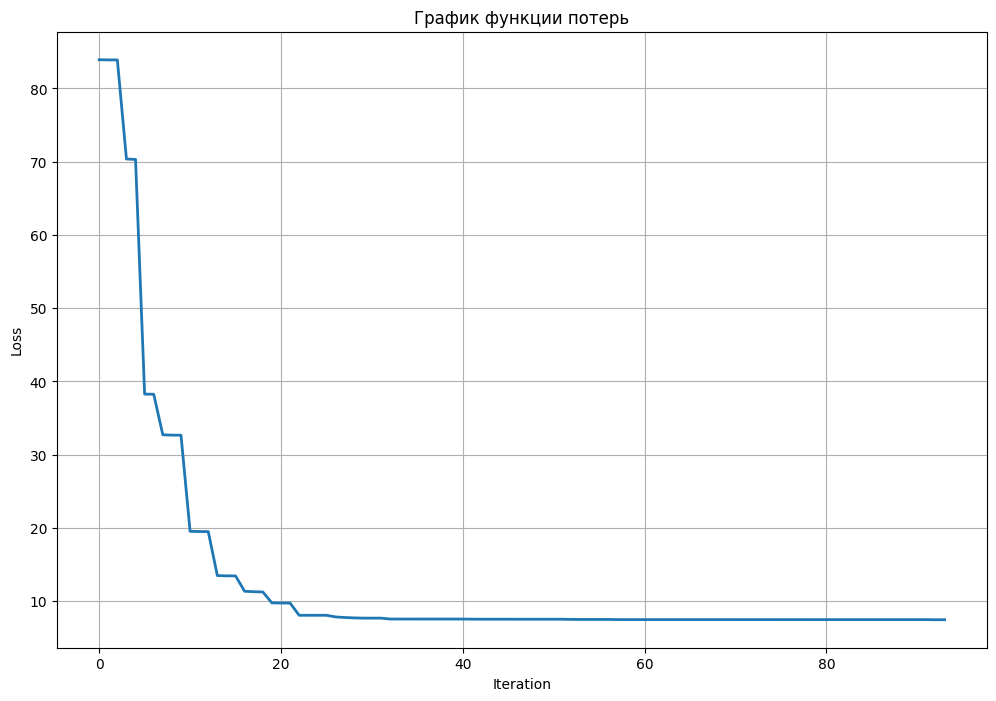

In [16]:
plt.figure(figsize=user_figsize)
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.grid()
plt.show

In [17]:
print('Оптимальные значения коэффициентов:')
print('L=' + str(np.round(weights[0]*L_b, 6)))
print('r=' + str(np.round(weights[1]*r_b, 3)))
print('C=' + str(np.round(weights[2]*C_b, 10)))

Оптимальные значения коэффициентов:
L=0.000145
r=0.024
C=6e-10


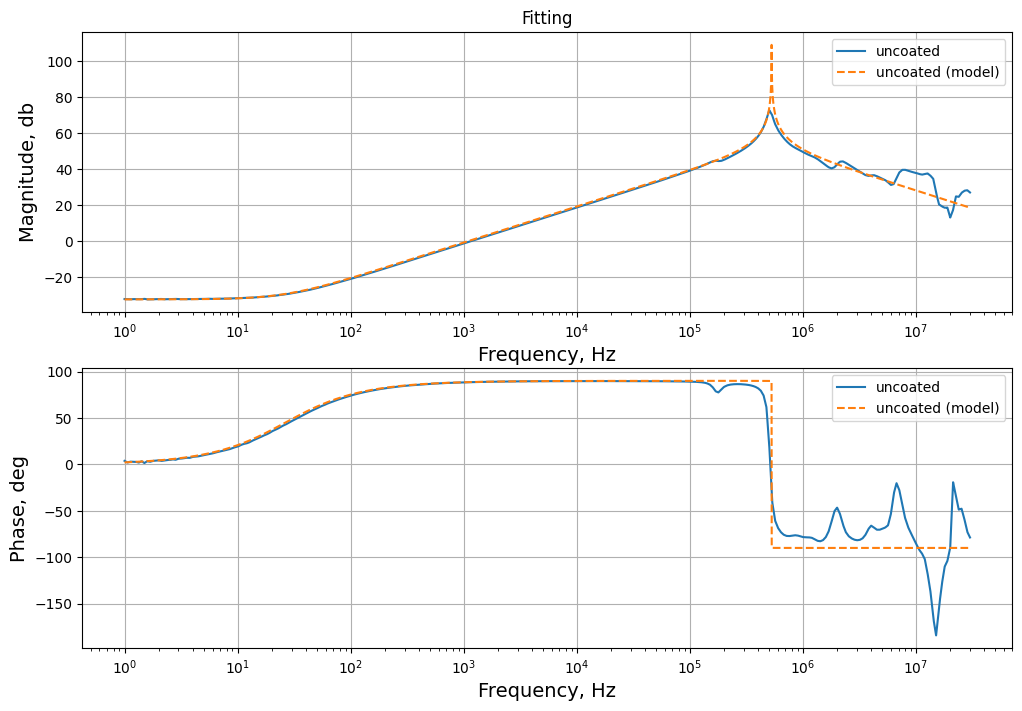

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=user_figsize)
abs_phase_dataset = reactor_model_gain(data[N_DATA][:, var.freq.value], L=weights[0]*L_b, r=weights[1]*r_b, C=weights[2]*C_b)

for idx, ax in enumerate(axs):
    ax.plot(data[N_DATA][:, var.freq.value], data[N_DATA][:, idx + 1], label=file_list[N_DATA])
    ax.plot(data[N_DATA][:, var.freq.value], abs_phase_dataset[idx], '--', label=file_list[N_DATA] + ' (model)')
    if idx == 0:
        ax.set_title('Fitting')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
    ax.axes.grid(True)
    ax.set_xscale('log')
    ax.legend()
plt.show()

### Оптимизация с формульным градиентом

In [19]:
def model_fit(X_train, y_train, lr_multiplier, lr_coeff, tolerance):

    iteration_max = 100000
    
    # Инициализируем коэффициенты.
    w_coeff_1 = np.array([0.9, 1.1, 1.2])

    grad = grad_func(freq=X_train, y=y_train, w=w_coeff_1)
    grad_norm = np.linalg.norm(grad, ord=None, axis=None)

    loss = loss_func(freq=X_train, y=y_train, w=w_coeff_1)
    loss_arr = [loss]
    
    for i in range(iteration_max):
        learning_rate = lr_multiplier
        while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))) < lr_coeff * learning_rate * grad_norm**2:
            learning_rate *= lr_multiplier
        
        w_coeff_1 -= learning_rate * grad
        
        grad = grad_func(freq=X_train, y=y_train, w=w_coeff_1)
        grad_norm = np.linalg.norm(grad, ord=None, axis=None)
        
        loss = loss_func(freq=X_train, y=y_train, w=w_coeff_1)
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        loss_arr.append(loss)
        
        print(i, loss_arr[-1])
        print('grad:', grad)
        print('grad_norm:', grad_norm)
        print('parameters:', w_coeff_1)
        
        if grad_norm < tolerance:
            break
    
    return w_coeff_1, loss_arr

In [20]:
weights1, losses1 = model_fit(
    X_train = data[N_DATA][:, var.freq.value],
    y_train = data[N_DATA][:, var.mag_db.value],
    lr_multiplier=0.5, #0.0001,
    lr_coeff = 0.5,
    tolerance=1e-1)

0 83.90242341178227
grad: [ 27.89585097 -17.61055209  17.115392  ]
grad_norm: 37.16512733134194
parameters: [0.89976858 1.10003359 1.19983373]
1 83.89931215225371
grad: [  0.87773993 -17.60963918  -3.13800173]
grad_norm: 17.90856985112994
parameters: [0.89966217 1.10010077 1.19976844]
2 70.37742725802829
grad: [-150.61998261   -2.43743737  -91.8158601 ]
grad_norm: 176.41562410670437
parameters: [0.84480342 2.20070321 1.39589354]
3 70.31390144146631
grad: [-17.77349736  -2.43515742 -11.45567535]
grad_norm: 21.28519903712289
parameters: [0.84537799 2.20071251 1.39624379]
4 38.44399931221893
grad: [ -4.67888224   0.20039204 -33.9434209 ]
grad_norm: 34.26496633672315
parameters: [1.95622157 2.35290985 2.1122235 ]
5 33.74294965561378
grad: [-110.02832055    0.21880762 -117.63279312]
grad_norm: 161.0706466671275
parameters: [1.99277534 2.35134429 2.37740648]
6 33.6438961104488
grad: [-12.80848      0.21948447 -36.13836628]
grad_norm: 38.34171163044881
parameters: [1.99361479 2.35134262 2.378

<function matplotlib.pyplot.show(close=None, block=None)>

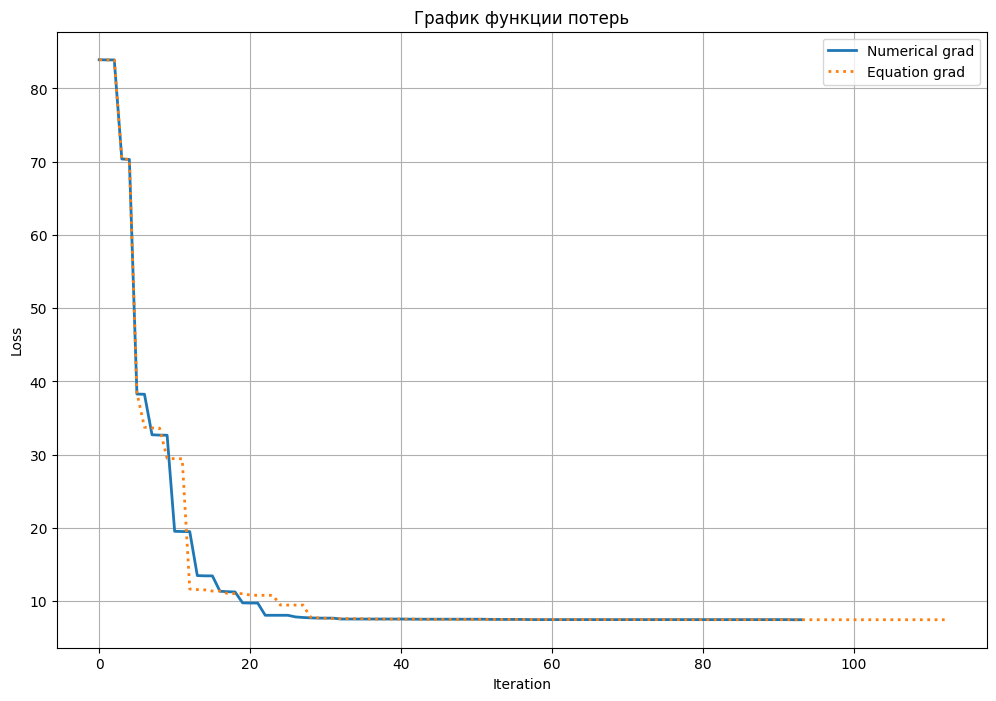

In [21]:
plt.figure(figsize=user_figsize)
plt.plot(losses, linewidth=2, label='Numerical grad')
plt.plot(losses1, ':', linewidth=2, label='Equation grad')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.legend()
plt.grid()
plt.show

In [22]:
print('Оптимальные значения коэффициентов (numerical grad):')
print('L=' + str(np.round(weights[0]*L_b, 6)))
print('r=' + str(np.round(weights[1]*r_b, 3)))
print('C=' + str(np.round(weights[2]*C_b, 10)))

print('Оптимальные значения коэффициентов (equation grad):')
print('L=' + str(np.round(weights1[0]*L_b, 6)))
print('r=' + str(np.round(weights1[1]*r_b, 3)))
print('C=' + str(np.round(weights1[2]*C_b, 10)))

Оптимальные значения коэффициентов (numerical grad):
L=0.000145
r=0.024
C=6e-10
Оптимальные значения коэффициентов (equation grad):
L=0.000146
r=0.024
C=6e-10
